In [1]:
import scanpy as sc
import custom_tools
import os
import numpy as np
import anndata as ad
import decoupler as dc
import seaborn as sns
from dataset import TissueDataset

Global seed set to 42


In [2]:
# Read json file
exp_name = "GATV2_NegativeLogLikelihood_month_04-12-2023"
job_id = "YyroGgMa_H4xn_ctP3C5Zw"
device =  custom_tools.get_device()
args  = custom_tools.load_json(f"../models/{exp_name}/{job_id}.json")
# args["num_node_features"] = 33
deg = None
if "PNA" in exp_name:
    deg = custom_tools.load_pickle(f"../models/{exp_name}/{job_id}_deg.pckl")
model = custom_tools.load_model(f"{job_id}_SD", path = f"../models/{exp_name}", model_type = "SD", args = args, deg=deg, device=device)

dataset = TissueDataset(os.path.join("../data/JacksonFischer", "month"),  "month")

Global seed set to 42


CPU is available on this device!
Target prediction: OSmonth


In [3]:
import embeddings
emd, related_data = embeddings.get_intermediate_embeddings_for_dataset(model, dataset, batch_size=1)

In [4]:
related_data

[DataBatch(x=[799, 33], edge_index=[2, 4622], y=[1], pos=[799, 2], osmonth=[1], clinical_type=[1], treatment=[1], disease_stage=[1], tumor_grade=[1], img_id=[1], p_id=[1], age=[1], disease_status=[1], dfs_month=[1], is_censored=[1], batch=[799], ptr=[2]),
 DataBatch(x=[720, 33], edge_index=[2, 4194], y=[1], pos=[720, 2], osmonth=[1], clinical_type=[1], treatment=[1], disease_stage=[1], tumor_grade=[1], img_id=[1], p_id=[1], age=[1], disease_status=[1], dfs_month=[1], is_censored=[1], batch=[720], ptr=[2]),
 DataBatch(x=[2535, 33], edge_index=[2, 14776], y=[1], pos=[2535, 2], osmonth=[1], clinical_type=[1], treatment=[1], disease_stage=[1], tumor_grade=[1], img_id=[1], p_id=[1], age=[1], disease_status=[1], dfs_month=[1], is_censored=[1], batch=[2535], ptr=[2]),
 DataBatch(x=[1092, 33], edge_index=[2, 6336], y=[1], pos=[1092, 2], osmonth=[1], clinical_type=[1], treatment=[1], disease_stage=[1], tumor_grade=[1], img_id=[1], p_id=[1], age=[1], disease_status=[1], dfs_month=[1], is_censore

In [5]:
embedding_arr = np.array(emd[0])
embedding_arr.shape
pid_list, img_id_list, osmonth_lst,  clinical_type_lst, tumor_grade_lst= [], [], [], [], []
for data in related_data:
    pid_list.append(str(data.p_id[0]))
    osmonth_lst.append(data.osmonth.item())
    img_id_list.append(data.img_id[0])
    clinical_type_lst.append(data.clinical_type[0])
    tumor_grade_lst.append(str(data.tumor_grade.item()))

embedding_arr.shape
embedding_arr.shape[1]

128

In [6]:
adata = ad.AnnData(embedding_arr)
adata.var_names = [f"emb_{i}" for i in range(embedding_arr.shape[1])]
adata.obs_names = img_id_list
adata.obs["img_id"] = img_id_list
adata.obs["osmonth"] = osmonth_lst
adata.obs["p_id"] = pid_list
adata.obs["clinical_type"] = clinical_type_lst
adata.obs["tumor_grade"] = tumor_grade_lst

adata.obs

,img_id,osmonth,p_id,clinical_type,tumor_grade
317ll,317ll,3.0,241-basel,TripleNeg,3
232ll,232ll,95.0,89-basel,TripleNeg,3
157,157,75.0,223-basel,HR+HER2-,1
336ur,336ur,23.0,270-basel,TripleNeg,3
15lr,15lr,37.0,166-basel,TripleNeg,3
...,...,...,...,...,...
60ll,60ll,21.0,254-basel,TripleNeg,3
191lr,191lr,20.0,189-basel,TripleNeg,3
254ll,254ll,61.0,144-basel,HR+HER2-,2
96ur,96ur,116.0,186-basel,HR+HER2-,2


In [7]:
sc.tl.pca(adata, svd_solver='arpack', random_state=0)
sc.pp.neighbors(adata)
sc.tl.umap(adata)


In [8]:
sc.tl.leiden(adata, key_added = "leiden")

In [11]:
adata.var_names

Index(['emb_0', 'emb_1', 'emb_2', 'emb_3', 'emb_4', 'emb_5', 'emb_6', 'emb_7',
       'emb_8', 'emb_9',
       ...
       'emb_118', 'emb_119', 'emb_120', 'emb_121', 'emb_122', 'emb_123',
       'emb_124', 'emb_125', 'emb_126', 'emb_127'],
      dtype='object', length=128)

/net/data.isilon/ag-saez/bq_arifaioglu/miniconda3/envs/py_gem/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


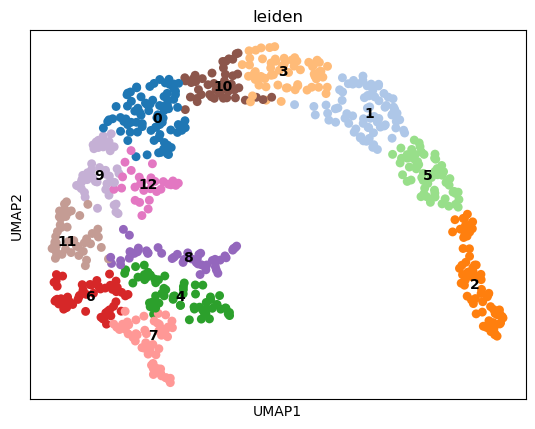

/net/data.isilon/ag-saez/bq_arifaioglu/miniconda3/envs/py_gem/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/net/data.isilon/ag-saez/bq_arifaioglu/miniconda3/envs/py_gem/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


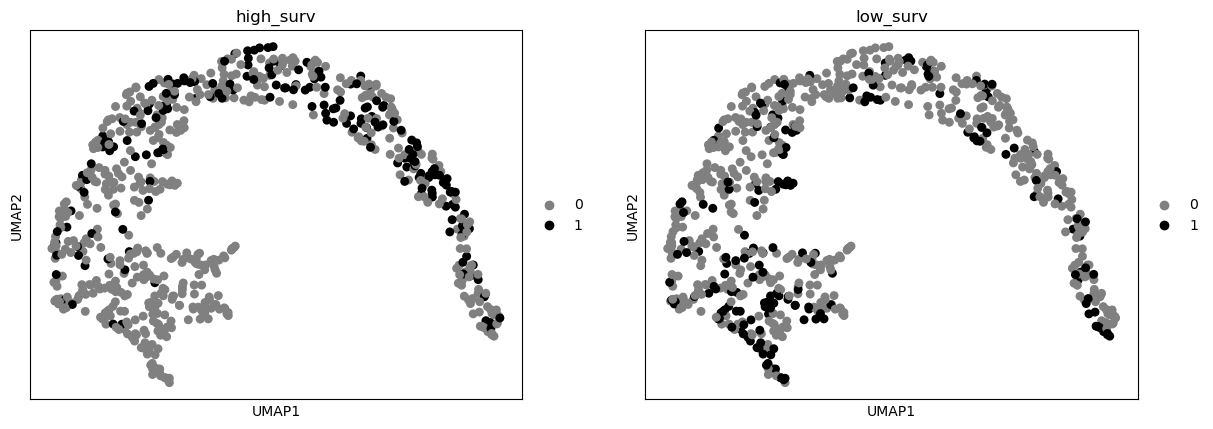

TypeError: dotplot() missing 1 required positional argument: 'var_names'

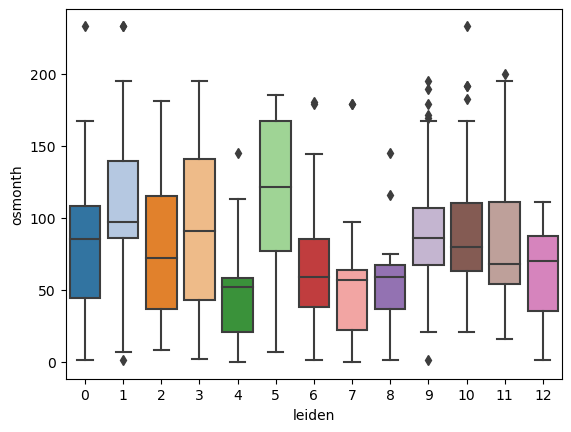

In [9]:
# sc.pl.umap(adata, color=["osmonth", "le"iden"])
upper_quartile = int(np.quantile(adata.obs["osmonth"], 0.75))
lower_quartile = int(np.quantile(adata.obs["osmonth"], 0.25))


adata.obs["high_surv"]="0"
adata.obs["low_surv"]="0"

adata.obs.loc[adata.obs["osmonth"]>upper_quartile, "high_surv" ] = "1"
adata.obs.loc[adata.obs["osmonth"]<lower_quartile, "low_surv" ] = "1"

cmap = sns.palettes.get_colormap("tab20")
color_dict = dict()

for ind, clust_index in enumerate(adata.obs["leiden"].cat.categories):
    color_dict[clust_index] = cmap.colors[ind]

sc.pl.umap(adata, color=["leiden"], palette=color_dict, legend_loc = 'on data')
sc.pl.umap(adata, color=["high_surv", "low_surv"], palette=["grey", "black"])
sns.boxplot(data=adata.obs, x="leiden", y="osmonth", palette= color_dict)
sc.pl.dotplot(adata, n_genes=5, groupby='bulk_labels', dendrogram=True)

sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
sc.pl.rank_genes_groups_dotplot(adata, n_genes=5, key=f"t-test", show=True, groupby=f"leiden")


/net/data.isilon/ag-saez/bq_arifaioglu/miniconda3/envs/py_gem/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/net/data.isilon/ag-saez/bq_arifaioglu/miniconda3/envs/py_gem/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


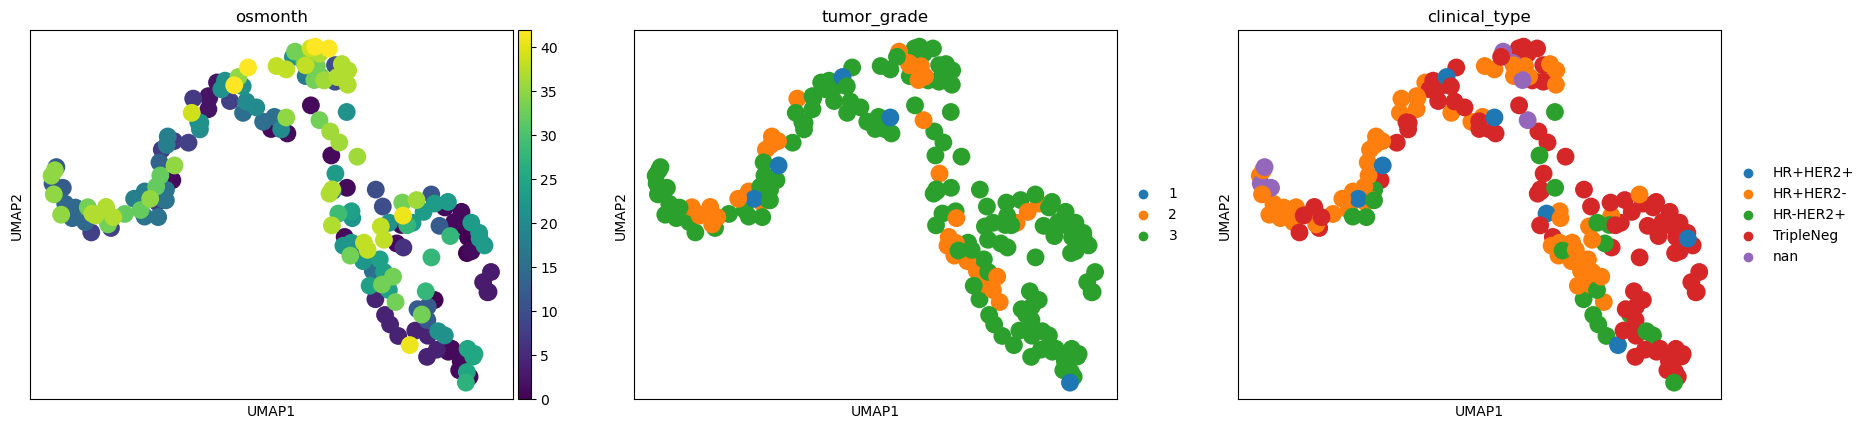

/net/data.isilon/ag-saez/bq_arifaioglu/miniconda3/envs/py_gem/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


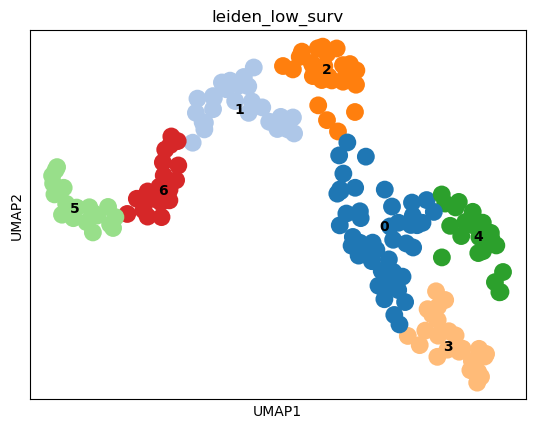

<Axes: xlabel='leiden_low_surv', ylabel='osmonth'>

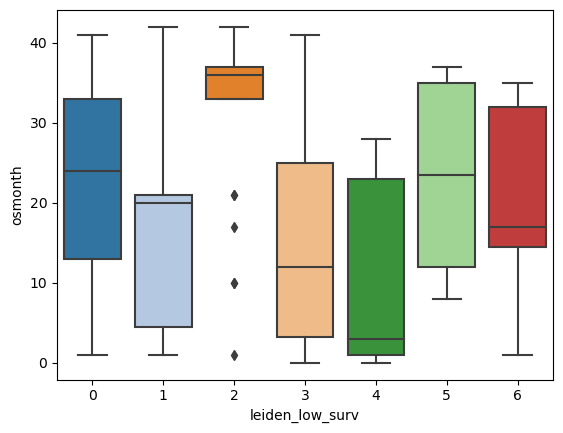

In [131]:
lower_quartile = int(np.quantile(adata.obs["osmonth"], 0.25))
adata_lower = adata[adata.obs["osmonth"]<lower_quartile,:].copy()

sc.tl.pca(adata_lower, svd_solver='arpack', random_state=0)
sc.pp.neighbors(adata_lower)
sc.tl.umap(adata_lower)

sc.tl.leiden(adata_lower, resolution=0.5, key_added = "leiden_low_surv")

color_dict = dict()
map = sns.palettes.get_colormap("tab20")
color_dict = dict()

for ind, clust_index in enumerate(adata_lower.obs["leiden_low_surv"].cat.categories):
    color_dict[clust_index] = cmap.colors[ind]

sc.pl.umap(adata_lower, color=["osmonth", "tumor_grade", "clinical_type"])
sc.pl.umap(adata_lower, color="leiden_low_surv", palette=color_dict, legend_loc = 'on data')
sns.boxplot(data=adata_lower.obs, x="leiden_low_surv", y="osmonth", palette= color_dict)
# sc.pl.violin(adata_lower, 'osmonth', groupby='leiden', palette=color_dict)

In [132]:
adata_clinical_subtype = adata[adata.obs["clinical_type"]=="HR+HER2-",:].copy()

"""
upper_quartile = int(np.quantile(adata_clinical_subtype.obs["osmonth"], 0.75))
lower_quartile = int(np.quantile(adata_clinical_subtype.obs["osmonth"], 0.25))


adata_clinical_subtype.obs["high_surv"]="0"
adata_clinical_subtype.obs["low_surv"]="0"

adata_clinical_subtype.obs.loc[adata_clinical_subtype.obs["osmonth"]>upper_quartile, "high_surv" ] = "1"
adata_clinical_subtype.obs.loc[adata_clinical_subtype.obs["osmonth"]<lower_quartile, "low_surv" ] = "1"
"""


'\nupper_quartile = int(np.quantile(adata_clinical_subtype.obs["osmonth"], 0.75))\nlower_quartile = int(np.quantile(adata_clinical_subtype.obs["osmonth"], 0.25))\n\n\nadata_clinical_subtype.obs["high_surv"]="0"\nadata_clinical_subtype.obs["low_surv"]="0"\n\nadata_clinical_subtype.obs.loc[adata_clinical_subtype.obs["osmonth"]>upper_quartile, "high_surv" ] = "1"\nadata_clinical_subtype.obs.loc[adata_clinical_subtype.obs["osmonth"]<lower_quartile, "low_surv" ] = "1"\n'

/net/data.isilon/ag-saez/bq_arifaioglu/miniconda3/envs/py_gem/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/net/data.isilon/ag-saez/bq_arifaioglu/miniconda3/envs/py_gem/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


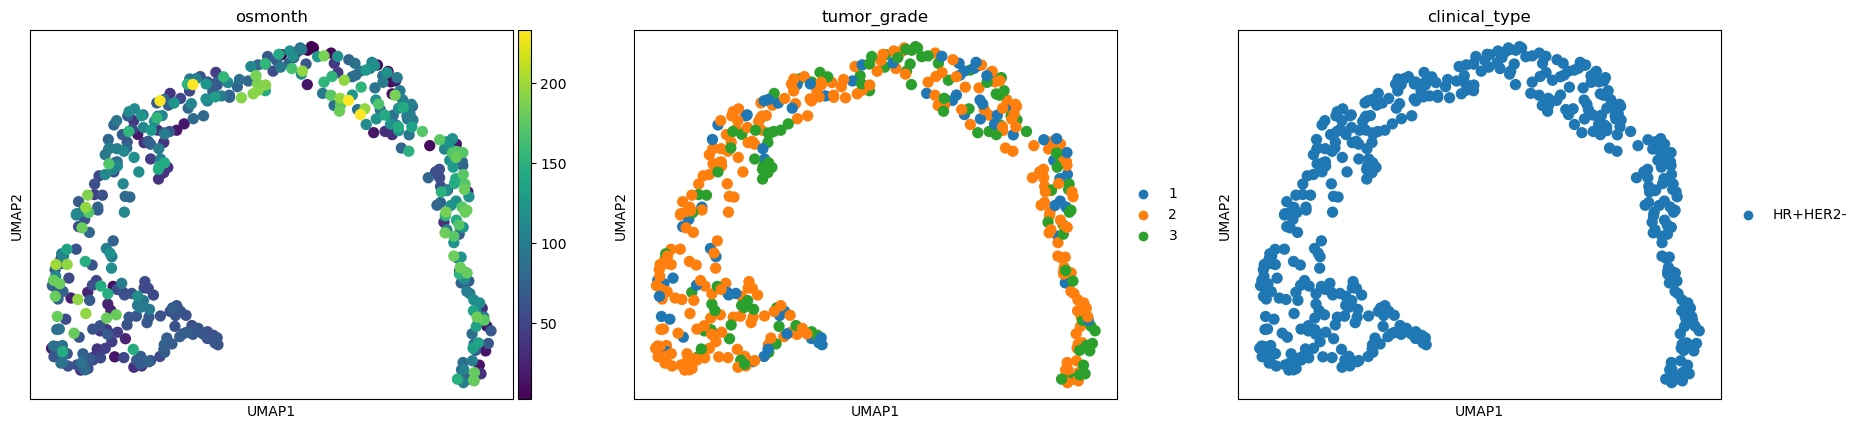

/net/data.isilon/ag-saez/bq_arifaioglu/miniconda3/envs/py_gem/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


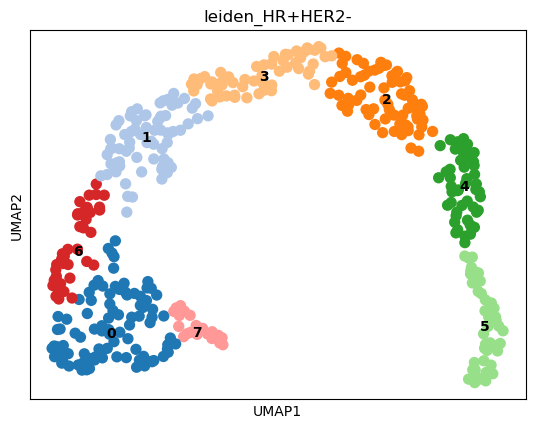

/net/data.isilon/ag-saez/bq_arifaioglu/miniconda3/envs/py_gem/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/net/data.isilon/ag-saez/bq_arifaioglu/miniconda3/envs/py_gem/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


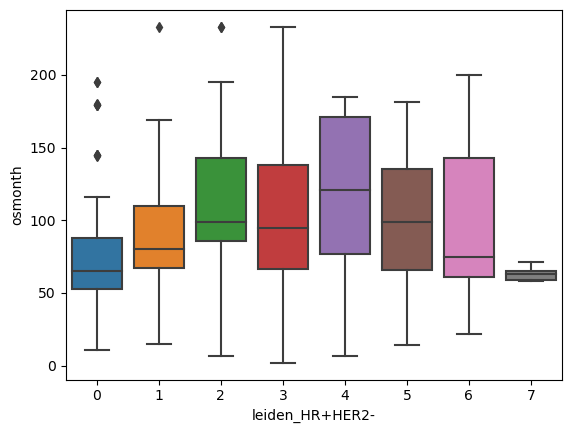

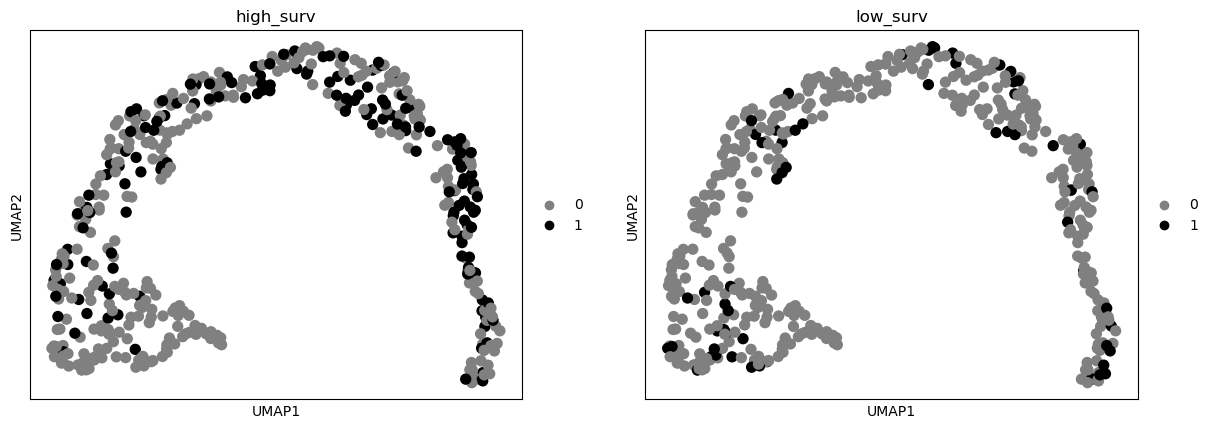

In [133]:
sc.tl.pca(adata_clinical_subtype, svd_solver='arpack', random_state=0)
sc.pp.neighbors(adata_clinical_subtype)
sc.tl.umap(adata_clinical_subtype)

sc.tl.leiden(adata_clinical_subtype, resolution=0.4, key_added = "leiden_HR+HER2-")

color_dict = dict()
map = sns.palettes.get_colormap("tab20")
color_dict = dict()

for ind, clust_index in enumerate(adata_clinical_subtype.obs["leiden_HR+HER2-"].cat.categories):
    color_dict[clust_index] = cmap.colors[ind]

sc.pl.umap(adata_clinical_subtype, color=["osmonth", "tumor_grade", "clinical_type"])
sc.pl.umap(adata_clinical_subtype, color="leiden_HR+HER2-", palette=color_dict, legend_loc = 'on data')
sns.boxplot(data=adata_clinical_subtype.obs, x="leiden_HR+HER2-", y="osmonth")
sc.pl.umap(adata_clinical_subtype, color=["high_surv", "low_surv"])

In [20]:
adata_exp = sc.read_h5ad("/net/data.isilon/ag-saez/bq_arifaioglu/home/Projects/GNNClinicalOutcomePrediction/data/out_data/adatafiles/concatenated_explanations.h5ad")
adata_exp.obs_names_make_unique()

/net/data.isilon/ag-saez/bq_arifaioglu/miniconda3/envs/py_gem/lib/python3.10/site-packages/anndata/_core/anndata.py:1897: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [22]:
adata_exp.var_names

Index(['H3K27me3', 'CK5', 'Fibronectin', 'CK19', 'CK8/18', 'Twist', 'CD68',
       'CK14', 'SMA', 'Vimentin', 'c-Myc', 'HER2', 'CD3', 'pHH3', 'Slug', 'ER',
       'PR', 'p53', 'CD44', 'CD45', 'GATA3', 'CD20', 'CAIX', 'E/P-cadherin',
       'Ki-67', 'EGFR', 'pS6', 'vWF/CD31', 'pmTOR', 'CK7', 'panCK',
       'CC3/cPARP', 'HH3'],
      dtype='object')

In [143]:
pdata = dc.get_pseudobulk(
    adata_exp,
    sample_col='img_id',
    groups_col='importance_hard',
    mode='mean',
    min_cells=0,
    min_counts=0
)

pdata

/net/data.isilon/ag-saez/bq_arifaioglu/miniconda3/envs/py_gem/lib/python3.10/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


AnnData object with n_obs × n_vars = 1462 × 33
    obs: 'clinical_type', 'img_id', 'p_id', 'tumor_grade', 'osmonth', 'importance_hard', 'psbulk_n_cells', 'psbulk_counts'
    layers: 'psbulk_props'

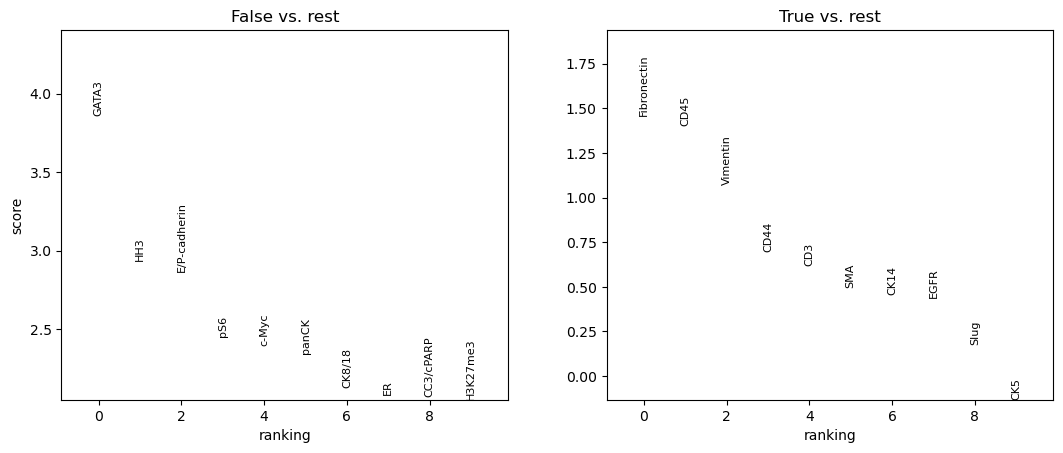

In [157]:
sc.tl.rank_genes_groups(pdata, 'importance_hard', method='t-test')
sc.pl.rank_genes_groups(pdata, n_genes=10, sharey=False)

In [152]:
print(adata_exp.X.shape)
print(adata_exp.X[~np.isnan(adata_exp.X).any(axis=1)].shape)

print(pdata.X.shape)
print(pdata.X[~np.isnan(pdata.X).any(axis=1)].shape)

(759541, 33)
(759541, 33)
(1462, 33)
(1462, 33)


In [16]:
adata_concat = sc.read_h5ad("/net/data.isilon/ag-saez/bq_arifaioglu/home/Projects/GNNClinicalOutcomePrediction/data/out_data/adatafiles/concatenated_explanations.h5ad")

In [17]:
adata.obs_names_make_unique()

In [18]:
adata

AnnData object with n_obs × n_vars = 731 × 128
    obs: 'img_id', 'osmonth', 'p_id', 'clinical_type', 'tumor_grade', 'leiden', 'high_surv', 'low_surv'
    uns: 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'high_surv_colors', 'low_surv_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [19]:
adata.var_names

Index(['emb_0', 'emb_1', 'emb_2', 'emb_3', 'emb_4', 'emb_5', 'emb_6', 'emb_7',
       'emb_8', 'emb_9',
       ...
       'emb_118', 'emb_119', 'emb_120', 'emb_121', 'emb_122', 'emb_123',
       'emb_124', 'emb_125', 'emb_126', 'emb_127'],
      dtype='object', length=128)